## Faces recognition example using eigenfaces and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


In [1]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [2]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
print(lfw_people.images.shape)

(1288, 50, 37)


In [3]:
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
print(X.shape)
n_features = X.shape[1]

(1288, 1850)


In [4]:
# the label to predict is the id of the person
y = lfw_people.target
y

array([5, 6, 3, ..., 5, 3, 5])

In [5]:
target_names = lfw_people.target_names
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'],
      dtype='|S17')

In [6]:
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [7]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)
pca.explained_variance_ratio_

Extracting the top 150 eigenfaces from 966 faces
done in 0.383s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.035s


array([ 0.19052055,  0.14642398,  0.07449245,  0.06027026,  0.05208752,
        0.03092085,  0.0247453 ,  0.02155773,  0.02026833,  0.0189656 ,
        0.01676956,  0.01471126,  0.01215219,  0.01104578,  0.01072541,
        0.00957809,  0.0091907 ,  0.0085879 ,  0.00814039,  0.00731398,
        0.00692265,  0.00671011,  0.0061762 ,  0.00597052,  0.00554608,
        0.00528951,  0.00514998,  0.00492384,  0.00471414,  0.00443973,
        0.00386262,  0.00381427,  0.00357771,  0.00345335,  0.0034389 ,
        0.00325782,  0.00315689,  0.00308425,  0.00294039,  0.00275817,
        0.00274362,  0.00262334,  0.00258043,  0.00256993,  0.00248045,
        0.00240326,  0.0023721 ,  0.00228402,  0.00219602,  0.00215996,
        0.00211393,  0.00202031,  0.00200039,  0.00197969,  0.00193735,
        0.0018751 ,  0.00181816,  0.00177189,  0.00175928,  0.00172015,
        0.00166091,  0.00164735,  0.00158107,  0.00155756,  0.00152856,
        0.00150983,  0.00144866,  0.0014459 ,  0.00141244,  0.00

In [8]:
###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 19.314s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [9]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.054s
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.85      0.76        13
     Colin Powell       0.85      0.83      0.84        60
  Donald Rumsfeld       0.72      0.78      0.75        27
    George W Bush       0.87      0.91      0.89       146
Gerhard Schroeder       0.88      0.88      0.88        25
      Hugo Chavez       1.00      0.80      0.89        15
       Tony Blair       0.93      0.72      0.81        36

      avg / total       0.86      0.85      0.85       322

[[ 11   1   1   0   0   0   0]
 [  2  50   1   6   0   0   1]
 [  2   0  21   4   0   0   0]
 [  0   7   5 133   1   0   0]
 [  0   1   0   1  22   0   1]
 [  0   0   0   2   1  12   0]
 [  1   0   1   7   1   0  26]]


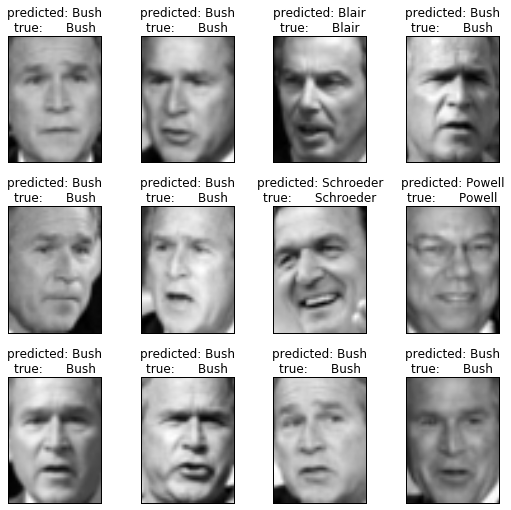

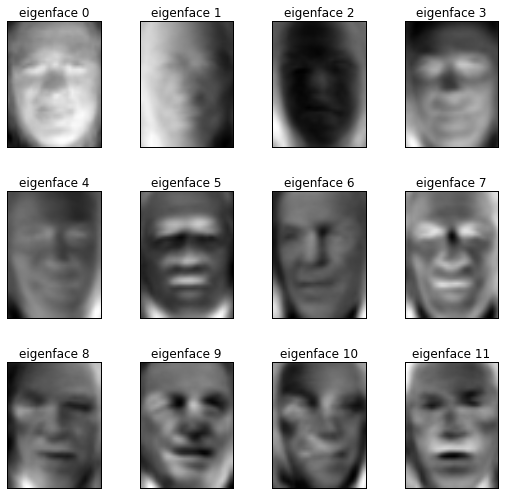

In [10]:
%matplotlib inline
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()